## Predicting the 3 month CLV with Python

In [1]:
#import the necessary library, load the dataset
import pandas as pd
df = pd.read_excel(r"C:\Users\Zachary_B\Desktop\dataset\Online Retail.xlsx")

In [2]:
df.shape

(541909, 8)

In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


As you might have noticed, we have used this dataset a few times in the previous chapters. With the knowledge we gained about this dataset from the previous chapters, we are going to first prepare our data by cleaning it up.

## Data cleanup

In [4]:
# lets check all our negative orders
df.loc[df['Quantity'] <= 0].shape

(10624, 8)

In [5]:
df.shape

(541909, 8)

In [6]:
#There are transactions with a negative Quantity value, which represent canceled orders.
# We are going to ignore those canceled orders for this exercise.
df = df.loc[df['Quantity'] > 0]

In [7]:
df.shape

(531285, 8)

In [8]:
# Dropping NaN records:We need to drop records with no CustomerID.
df = df[pd.notnull(df['CustomerID'])]

In [9]:
df.shape

(397924, 8)

In [10]:
#Another cleanup we need to do is to handle incomplete data. If you recall from previous chapters, the transaction data for
#the last month is incomplete we are going to ignore the transactions in the last month.
df = df.loc[df['InvoiceDate'] < '2011-12-01']

In [11]:
df.shape

(380620, 8)

In [12]:
#Lastly, we need to create a column for the total sales value for each transaction. Take a look at the following code:
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [13]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [14]:
#We are summing up all of the Sales values for each customer and order, and taking the last transaction time for the given order as InvoiceDate.
#This way we now have a DataFrame,orders_df, as we need to know about each order that each customer placed.
orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({'Sales': sum,'InvoiceDate': max})

In [15]:
orders_df

Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00
...                        ...                 ...
18283.0    578262       313.65 2011-11-23 13:27:00
           579673       223.61 2011-11-30 12:59:00
18287.0    554065       765.28 2011-05-22 10:39:00
           570715      1001.32 2011-10-12 10:23:00
           573167        70.68 2011-10-28 09:29:00

[17758 rows x 2 columns]

## Data analysis

In order to calculate the CLV, we need to know the frequency, recency, and total amount of purchases by each customer.
We are going to compute basic information about each customer's average and lifetime purchase amount, aswell as each 
customer's duration and frequency of purchases. Take a look at the following code

In [16]:
#We are using four customer aggregation functions: groupby_mean, groupby_count,purchase_duration, and avg_frequency.
#The first function, groupby_mean, simply computes the average for each group 
#The second function, groupby_count,simply counts the number of records in each group.
#The purchase_duration function counts the number of days between the first and last invoice dates in each group.
#The avg_frequency function calculates the average number of days between orders by dividing purchase_duration by the number of orders.
def groupby_mean(x):
    return x.mean()
def groupby_count(x):
    return x.count()
def purchase_duration(x):
    return (x.max() - x.min()).days
def avg_frequency(x):
    return (x.max() - x.min()).days/x.count()
groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

summary_df = orders_df.reset_index().groupby('CustomerID').agg({'Sales': [min, max, sum, groupby_mean, groupby_count],
                                                                'InvoiceDate': [min, max, purchase_duration, avg_frequency]})

In [17]:
summary_df

Sales                                          \
                 min       max       sum           avg count   
CustomerID                                                     
12346.0     77183.60  77183.60  77183.60  77183.600000   1.0   
12347.0       382.52   1294.32   4085.18    680.863333   6.0   
12348.0       227.44    892.80   1797.24    449.310000   4.0   
12349.0      1757.55   1757.55   1757.55   1757.550000   1.0   
12350.0       334.40    334.40    334.40    334.400000   1.0   
...              ...       ...       ...           ...   ...   
18280.0       180.60    180.60    180.60    180.600000   1.0   
18281.0        80.82     80.82     80.82     80.820000   1.0   
18282.0       100.21    100.21    100.21    100.210000   1.0   
18283.0         1.95    313.65   1886.88    125.792000  15.0   
18287.0        70.68   1001.32   1837.28    612.426667   3.0   

                   InvoiceDate                                        \
                           min                 max purchase_duration   
CustomerID                                                             
12346.0    2011-01-18 10:01:00 2011-01-18 10:01:00                 0   
12347.0    2010-12-07 14:57:00 2011-10-31 12:25:00               327   
12348.0    2010-12-16 19:09:00 2011-09-25 13:13:00               282   
12349.0    2011-11-21 09:51:00 2011-11-21 09:51:00                 0   
12350.0    2011-02-02 16:01:00 2011-02-02 16:01:00                 0   
...                        ...                 ...               ...   
18280.0    2011-03-07 09:52:00 2011-03-07 09:52:00                 0   
18281.0    2011-06-12 10:53:00 2011-06-12 10:53:00                 0   
18282.0    2011-08-05 13:35:00 2011-08-05 13:35:00                 0   
18283.0    2011-01-06 14:14:00 2011-11-30 12:59:00               327   
18287.0    2011-05-22 10:39:00 2011-10-28 09:29:00               158   

                               
           purchase_frequency  
CustomerID                     
12346.0              0.000000  
12347.0             54.500000  
12348.0             70.500000  
12349.0              0.000000  
12350.0              0.000000  
...                       ...  
18280.0              0.000000  
18281.0              0.000000  
18282.0              0.000000  
18283.0             21.800000  
18287.0             52.666667  

[4298 rows x 9 columns]

In [18]:
import matplotlib.pyplot as plt

In [19]:
#We clean up the column names of the DataFrame, summary_df, in the first line.

summary_df.columns = ['_'.join(col).lower() for col in summary_df.columns]

In [20]:
summary_df

,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
CustomerID,,,,,,,,,
12346.0,77183.60,77183.60,77183.60,77183.600000,1.0,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.000000
12347.0,382.52,1294.32,4085.18,680.863333,6.0,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.500000
12348.0,227.44,892.80,1797.24,449.310000,4.0,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.500000
12349.0,1757.55,1757.55,1757.55,1757.550000,1.0,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.000000
12350.0,334.40,334.40,334.40,334.400000,1.0,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.000000
...,...,...,...,...,...,...,...,...,...
18280.0,180.60,180.60,180.60,180.600000,1.0,2011-03-07 09:52:00,2011-03-07 09:52:00,0,0.000000
18281.0,80.82,80.82,80.82,80.820000,1.0,2011-06-12 10:53:00,2011-06-12 10:53:00,0,0.000000
18282.0,100.21,100.21,100.21,100.210000,1.0,2011-08-05 13:35:00,2011-08-05 13:35:00,0,0.000000


In [21]:
#Then, we are only taking the customers who have made at least two or more purchases, which represents repeat customers. 

summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]

In [22]:
summary_df.shape

(2692, 9)

In [23]:
summary_df.groupby(by='sales_count')['sales_avg'].count().head(19)

sales_count
2.0     745
3.0     512
4.0     379
5.0     228
6.0     171
7.0     132
8.0      97
9.0      60
10.0     45
11.0     54
12.0     47
13.0     29
14.0     19
15.0     24
16.0     13
17.0     15
18.0     11
19.0     15
20.0     10
Name: sales_avg, dtype: int64

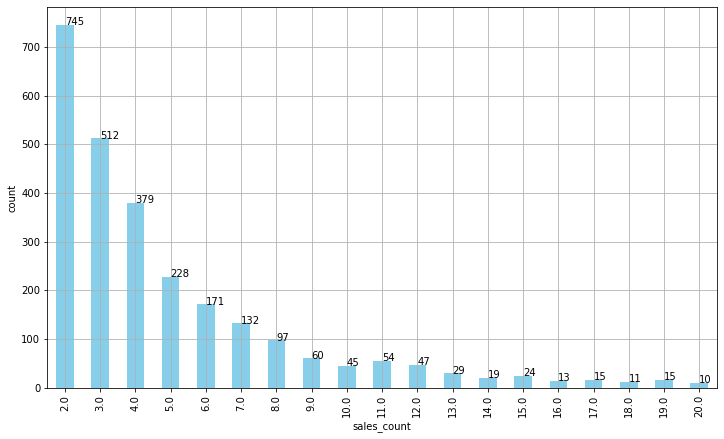

In [25]:
#Lastly, we group by the sales_count column and count how many customers belong to each category.

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])
if __name__ == '__main__':
    # creating data on which bar chart will be plot
    x = ["2.0", "3.0", "4.0", "5.0", "6.0", "7.0", "8.0", "9.0", "10.0", "11.0", "12.0",
         "13.0", "14.0", "15.0", "16.0", "17.0", "18.0", "19.0", "20.0"]
    y = [745, 512, 379, 228, 171, 132, 97, 60, 45, 54, 47, 29, 19,
         24, 13, 15, 11, 15, 10 ]
addlabels(x, y)

ax = summary_df.groupby('sales_count').count()['sales_avg'][:20].plot(
kind='bar',
color='skyblue',
figsize=(12,7),
grid=True
)
ax.set_ylabel('count')
plt.show()

In [ ]:
# Let's take a look at the average number of days between purchases for these repeat customers. Take a look at the following code:

ax = summary_df['invoicedate_purchase_frequency'].hist(
bins=20,
color='skyblue',
rwidth=0.7,
figsize=(12,7)
)
ax.set_xlabel('avg. number of days between purchases')
ax.set_ylabel('count')
plt.show()

## Predicting the 3 month CLV

We are going to first slice the data into chunks of 3 months and take the last 3 months data as the target for predictions and the rest as the features.
We will first prepare our data for model building and then train a linear regression model for the 3 month customer value predictions.

### Data preparation

In [ ]:
#Since we want to predict the 3 month customer value, we are breaking down the data into chunks of 3 months for each customer.
clv_freq = '3M'
data_df = orders_df.reset_index().groupby([
'CustomerID',
pd.Grouper(key='InvoiceDate', freq=clv_freq)
]).agg({
'Sales': [sum, groupby_mean, groupby_count],
})
data_df.columns = ['_'.join(col).lower() for col in data_df.columns]
data_df = data_df.reset_index()

In [ ]:
data_df.head(10)

In [ ]:
#let's encode the InvoiceDate column values so that they are easier to read than the current date format.
date_month_map = {
str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(
sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True)
)
}
data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[str(x)[:10]])

In [ ]:
data_df.head(10)

In [ ]:
# we need to transform this data into tabular data, where the rows represent the individual customers and the columns represent each feature.
features_df = pd.pivot_table(
data_df.loc[data_df['M'] != 'M_1'],
values=['sales_sum', 'sales_avg', 'sales_count'],
columns='M',
index='CustomerID'
)
features_df.columns = ['_'.join(col) for col in features_df.columns]

In [ ]:
features_df.head(10)

In [ ]:
#Encode the NaN values with 0.0 
features_df = features_df.fillna(0)

In [ ]:
# Now that we have built the features DataFrame, let's build the target variables. Take a look at the following code:
response_df = data_df.loc[
data_df['M'] == 'M_1',
['CustomerID', 'sales_sum']
]
response_df.columns = ['CustomerID', 'CLV_'+clv_freq]

In [ ]:
response_df.head(10)

In [ ]:
#There is only one thing left to build, which is a sample set for building machine learning models, combining features and response data together.
sample_set_df = features_df.merge(
response_df,
left_index=True,
right_on='CustomerID',
how='left'
)
sample_set_df = sample_set_df.fillna(0)

In [ ]:
sample_set_df

# Linear regression

In [ ]:
#we are going to split the sample set into train and test sets
from sklearn.model_selection import train_test_split
target_var = 'CLV_'+clv_freq
all_features = [x for x in sample_set_df.columns if x not in ['CustomerID',
target_var]]
x_train, x_test, y_train, y_test = train_test_split(
sample_set_df[all_features],
sample_set_df[target_var],
test_size=0.3
)


In [ ]:
#Train a linear regression model with our dataset
from sklearn.linear_model import LinearRegression
reg_fit = LinearRegression()
reg_fit.fit(x_train, y_train)

In [ ]:
#First, you can get the intercept of the linear regression equation, using the intercept_ attribute of the LinearRegression object
reg_fit.intercept_

In [ ]:
#Find the fitted linear regression model's coefficients, using the coef_ attribute
reg_fit.coef_

In [ ]:
# Find the coefficients of each feature of the fitted regression model 
coef = pd.DataFrame(list(zip(all_features, reg_fit.coef_)))
coef.columns = ['feature', 'coef']

coef

# Evaluating regression model performance

In [ ]:
#Get the prediction output from our model 
train_preds = reg_fit.predict(x_train)
test_preds = reg_fit.predict(x_test)

In [ ]:
test_preds

In [ ]:
#Import the R2 and the MAE - import them into your environment. 
from sklearn.metrics import r2_score, median_absolute_error

In [ ]:
#Compute the R2 and MAE numbers
r2_score(y_true=y_train, y_pred=train_preds)
median_absolute_error(y_true=y_train, y_pred=train_preds)

R-Squared

In [ ]:
# Print the insample and outsample of the r2
print('In-Sample R-Squared: %0.4f' %r2_score(y_true=y_train,y_pred=train_preds))
print('Out-Sample R-Squared: %0.4f' %r2_score(y_true=y_test,y_pred=test_preds))

Median Absolute Error

In [ ]:
print('In-Sample MSE: %0.4f' %median_absolute_error(y_true=y_train,y_pred=train_preds))
print('Out-Sample MSE: %0.4f' %median_absolute_error(y_true=y_test,y_pred=test_preds))

In [ ]:
#Lastly, let's take a look at the scatter plot of predicted versus actual
plt.scatter(y_test, test_preds)
plt.plot([0, max(y_test)], [0, max(test_preds)], color='gray', lw=1, linestyle='--')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Out-of-Sample Actual vs. Predicted')
plt.grid()
plt.show()